# Comparing Russell Funk's CD index data to Dimensions on GBQ calculations

Prerequisites for running this notebook:

* You need to have run the SQL to write the full CD index tables, as defined in the notebook ** Calculating the CD index using Dimensions on Google BigQuery**, for all, journals and pubmed articles.
* You need to have access to the sample dataset from Russell Funk

In [ ]:
import datetime
from time import sleep
from string import Template
import pandas as pd
import numpy as np
import re
import os
import shutil
import pandas as pd
import itertools
from textblob import Word # making singulars and plural
import tqdm
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import gspread
from gspread_dataframe import set_with_dataframe
from google.colab import auth
from google.auth import default
from google.cloud import bigquery

# Authenticate Google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Get the tables with all fields and nesting for the GBQ Dimensions tables
def gbq(sql, verbose=True):
  if verbose:
    print("==========\nQuerying:")
    print(sql)
    print("...")
  df = pd.io.gbq.read_gbq(sql, project_id = gbq_project_id, )
  if verbose:
    print("\t...loaded ", len(df), " records")
    display(df)
  return df

gbq_project_id = "[your GBQ billing/writing project]"
table_prefix = "[your dataset].[your table name prefix]"

# Private
If ever publish this then this needs to be deleted

In [ ]:
gbq_project_id = "ds-data-solutions-gbq"
table_prefix = "joerg.funk"
cdindex_gbq_table_name = "reports-dimensions-ai.precomputed.publications_cd_index"

# Writing Funk's data to GBQ
We received large CSV files but in GBQ it will be easier for us to merge them and compare the results. Since we only need to do this once there are if-statements that avoid running these accidentally for no gain.

In [ ]:
# Only do this once if we get new data
write_orig_data = False
if write_orig_data:
  print("\n", "="*20)
  print("Reading WoS data...")
  wos_data = pd.read_csv("/content/wos_2017_cdindex_cross_20190711_sample_1M.csv.gz")
  print(f"...read {len(wos_data)} records")
  display(wos_data.head())
  display(wos_data.describe())
  print("Writing to GBQ...")
  wos_data.to_gbq(destination_table = f"{table_prefix}_wos_cds",
                   project_id = gbq_project_id, if_exists="replace")
  print("..done")

  print("\n", "="*20)
  print("Reading PubMed data...")
  pubmed_data = pd.read_csv("/content/pumbed_cdindex.csv")
  print(f"...read {len(pubmed_data)} records")
  display(pubmed_data.head())
  display(pubmed_data.describe())
  print("Writing to GBQ...")
  pubmed_data.to_gbq(destination_table = f"{table_prefix}_pubmed_cds",
                   project_id = gbq_project_id, if_exists="replace")
  print("..done")

write_merged_data = False
if write_merged_data:
  print("Merging ")
  query = f"""
  CREATE OR REPLACE TABLE `{gbq_project_id}.{table_prefix}_all`
  AS
  (
    SELECT DISTINCT
    publications.id,
    publications.doi,
    publications.pmid,
    publications.type,
    publications.year,
    publications.journal.id as journal_id,
    publications.journal.title as journal_title,
    publications.category_for.first_level.full[SAFE_OFFSET(0)].code AS for1_code,
    publications.category_for.first_level.full[SAFE_OFFSET(0)].name AS for1_name,
    publications.citations_count,
    ARRAY_LENGTH(publications.reference_ids) as reference_count,

    funk_pubmed.cd_5  AS cd_orig_pubmed,
    funk_wos.cd_5     AS cd_orig_wos,
    cd_all.cd_5       AS cd_qbq_all,
    cd_journals.cd_5  AS cd_gbq_journals,
    cd_pubmed.cd_5    AS cd_gbq_pubmed

    FROM `dimensions-ai.data_analytics.publications` AS publications
    LEFT JOIN `{gbq_project_id}.{table_prefix}_pubmed_cds`
      AS funk_pubmed
      ON funk_pubmed.pmid = CAST(publications.pmid AS INT64)
    LEFT JOIN  `{gbq_project_id}.{table_prefix}_wos_cds`
      AS funk_wos
      ON LOWER(funk_wos.doi_1) = LOWER(publications.doi)
    LEFT JOIN `reports-dimensions-ai.precomputed.publications_cd_index_all`
        AS cd_all
        ON publications.id = cd_all.id
    LEFT JOIN `reports-dimensions-ai.precomputed.publications_cd_index_journals`
        AS cd_journals
        ON publications.id = cd_journals.id
    LEFT JOIN `reports-dimensions-ai.precomputed.publications_cd_index_pubmed`
        AS cd_pubmed
        ON publications.id = cd_pubmed.id
  )
  """
  client = bigquery.Client(project=gbq_project_id)
  tmp = client.query(query)
  while not tmp.done():
    sleep(5)

In [ ]:
cd_columns = [
    "cd_orig_pubmed",
    "cd_orig_wos",
    "cd_qbq_all",
    "cd_gbq_journals",
    "cd_gbq_pubmed"]

## Statistical attributes over each table

In [ ]:
all_stats = pd.DataFrame()
for cd_column in cd_columns:
  sql = f"""
  SELECT
    COUNT(DISTINCT id) AS count,
    MIN({cd_column}) AS min,
    MAX({cd_column}) AS max,
    AVG({cd_column}) AS mean,
    STDDEV({cd_column}) AS std,
    APPROX_QUANTILES({cd_column}, 100) AS quantiles
  FROM `{gbq_project_id}.{table_prefix}_all`
  WHERE {cd_column} IS NOT NULL
  """
  tmp = gbq(sql, False)
  tmp["source"] = cd_column
  all_stats = pd.concat([all_stats, tmp], axis=0)
for q in [0,25,50,75,95,99,100]:
  all_stats[f"q_{q}"] = all_stats['quantiles'].apply(lambda x: x[q])
all_stats.drop(columns=["quantiles"], inplace=True)
all_stats.set_index("source", inplace=True)
all_stats

,count,min,max,mean,std,q_0,q_25,q_50,q_75,q_95,q_99,q_100
source,,,,,,,,,,,,
cd_orig_pubmed,2326769,-1.0,1.0,-0.005869,0.110063,-1.0,-0.015206,-0.003824,-0.000285,0.037037,0.444444,1.0
cd_orig_wos,836576,-1.0,1.0,0.008392,0.122789,-1.0,-0.007619,-0.001351,0.000000,0.023697,1.000000,1.0
cd_qbq_all,79095505,-1.0,1.0,0.171102,0.380229,-1.0,-0.002289,0.000000,0.005562,1.000000,1.000000,1.0
cd_gbq_journals,38612176,-1.0,1.0,0.003999,0.084535,-1.0,-0.005970,-0.000694,0.000000,0.028708,0.294118,1.0
cd_gbq_pubmed,28165467,-1.0,1.0,0.154929,0.366097,-1.0,-0.004484,-0.000181,0.004437,1.000000,1.000000,1.0


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
display(all_stats)

,count,min,max,mean,std,q_0,q_25,q_50,q_75,q_95,q_99,q_100
source,,,,,,,,,,,,
cd_orig_pubmed,2326769,-1.00,1.00,-0.01,0.11,-1.00,-0.02,-0.00,-0.00,0.04,0.44,1.00
cd_orig_wos,836576,-1.00,1.00,0.01,0.12,-1.00,-0.01,-0.00,0.00,0.02,1.00,1.00
cd_qbq_all,79095505,-1.00,1.00,0.17,0.38,-1.00,-0.00,0.00,0.01,1.00,1.00,1.00
cd_gbq_journals,38612176,-1.00,1.00,0.00,0.08,-1.00,-0.01,-0.00,0.00,0.03,0.29,1.00
cd_gbq_pubmed,28165467,-1.00,1.00,0.15,0.37,-1.00,-0.00,-0.00,0.00,1.00,1.00,1.00


## Histograms for all CD indices

In [ ]:
all_hist = pd.DataFrame()
for cd_column in cd_columns:
  sql = f"""
  SELECT
    ROUND({cd_column}*100,0),
    COUNT(DISTINCT id) AS count,
  FROM `{gbq_project_id}.{table_prefix}_all`
  WHERE {cd_column} IS NOT NULL
  GROUP BY 1
  ORDER BY 1 ASC
  """
  tmp = gbq(sql, False)
  tmp["source"] = cd_column
  all_hist = pd.concat([all_hist, tmp], axis=0)
all_hist

,f0_,count,source
0,-100.00,4263,cd_orig_pubmed
1,-96.00,1,cd_orig_pubmed
2,-94.00,1,cd_orig_pubmed
3,-91.00,1,cd_orig_pubmed
4,-89.00,2,cd_orig_pubmed
...,...,...,...
194,96.00,229,cd_gbq_pubmed
195,97.00,156,cd_gbq_pubmed
196,98.00,95,cd_gbq_pubmed
197,99.00,32,cd_gbq_pubmed


In [ ]:
all_hist.rename(columns={"f0_" : "cd_bucket"}, inplace=True)
all_hist["cd_buckets"] = (all_hist.cd_bucket/100)#.apply(lambda x :f'{x:1.2f}')
all_hist

,cd_bucket,count,source,cd_buckets
0,-100.00,4263,cd_orig_pubmed,-1.00
1,-96.00,1,cd_orig_pubmed,-0.96
2,-94.00,1,cd_orig_pubmed,-0.94
3,-91.00,1,cd_orig_pubmed,-0.91
4,-89.00,2,cd_orig_pubmed,-0.89
...,...,...,...,...
194,96.00,229,cd_gbq_pubmed,0.96
195,97.00,156,cd_gbq_pubmed,0.97
196,98.00,95,cd_gbq_pubmed,0.98
197,99.00,32,cd_gbq_pubmed,0.99


In [ ]:
fig = px.line(all_hist, x="cd_buckets", y="count", color="source" )
fig.show()

## Distribution over publiction year


In [ ]:
all_trends = pd.DataFrame()
for cd_column in cd_columns:
  sql = f"""
  SELECT
    year,
    AVG({cd_column}) as average_cd
  FROM `{gbq_project_id}.{table_prefix}_all`
  WHERE {cd_column} IS NOT NULL
  GROUP BY 1
  ORDER BY 1 ASC
  """
  tmp = gbq(sql, False)
  tmp["source"] = cd_column
  all_trends = pd.concat([all_trends, tmp], axis=0)
all_trends

,year,average_cd,source
0,1930,0.18,cd_orig_pubmed
1,1931,0.15,cd_orig_pubmed
2,1932,0.20,cd_orig_pubmed
3,1933,0.16,cd_orig_pubmed
4,1934,0.17,cd_orig_pubmed
...,...,...,...
157,2019,0.05,cd_gbq_pubmed
158,2020,0.04,cd_gbq_pubmed
159,2021,0.03,cd_gbq_pubmed
160,2022,0.02,cd_gbq_pubmed


In [ ]:

fig = px.line(all_trends[(all_trends.year>=1945) & (all_trends.year<=2010) ], x="year", y="average_cd", facet_col="source" )
fig.show()

In [ ]:

fig = px.line(all_trends[(all_trends.year>=1945) & (all_trends.year<=2010) & all_trends.source.str.contains("bq")], x="year", y="average_cd", color="source", width=600)
fig.show()

## Are disruptive PubMed papers of Funk and Sixt the same?

In [ ]:
top_n=20000
sql = f"""
DECLARE top_n INT64 DEFAULT {top_n};
WITH raw_data AS
(
  SELECT
  id,
  cd_gbq_pubmed,
  ROW_NUMBER() OVER(ORDER BY cd_gbq_pubmed DESC) as rk_gbq_pubmed,
  cd_orig_pubmed,
  ROW_NUMBER() OVER(ORDER BY cd_orig_pubmed DESC) as rk_orig_pubmed,

  FROM `ds-data-solutions-gbq.joerg.funk_all` as fall
  WHERE fall.cd_gbq_pubmed IS NOT NULL AND fall.cd_orig_pubmed IS NOT NULL
)

SELECT MIN(cd_gbq_pubmed) AS min_cd_gbq_pubmed, MIN(cd_orig_pubmed) AS min_cd_orig_pubmed,
 COUNT(DISTINCT id ) as nr_overlap

FROM raw_data
WHERE rk_gbq_pubmed <= top_n AND rk_orig_pubmed <= top_n
"""
tmp = gbq(sql,verbose=False).iloc[0]

In [ ]:
print(f"In the top {top_n} disruptive papers in original and gbq pubmed publications we have {tmp.nr_overlap/top_n:.2%} overlap")

In the top 20000 disruptive papers in original and gbq pubmed publications we have 68.46% overlap


In [ ]:
sql="""
  SELECT
  cd_gbq_pubmed,
  cd_orig_pubmed,
  FROM `ds-data-solutions-gbq.joerg.funk_all` as fall
  WHERE fall.cd_gbq_pubmed IS NOT NULL AND fall.cd_orig_pubmed IS NOT NULL
"""
tmp =gbq(sql)

Querying:

  SELECT 
  cd_gbq_pubmed, 
  cd_orig_pubmed,
  FROM `ds-data-solutions-gbq.joerg.funk_all` as fall
  WHERE fall.cd_gbq_pubmed IS NOT NULL AND fall.cd_orig_pubmed IS NOT NULL

...
	...loaded  2326712  records


,cd_gbq_pubmed,cd_orig_pubmed
0,-0.00,-0.00
1,-0.01,-0.03
2,0.00,0.10
3,0.10,0.20
4,-0.00,-0.01
...,...,...
2326707,0.00,0.00
2326708,0.00,0.00
2326709,-0.00,0.00
2326710,-0.00,0.00


<Axes: xlabel='cd_gbq_pubmed', ylabel='cd_orig_pubmed'>

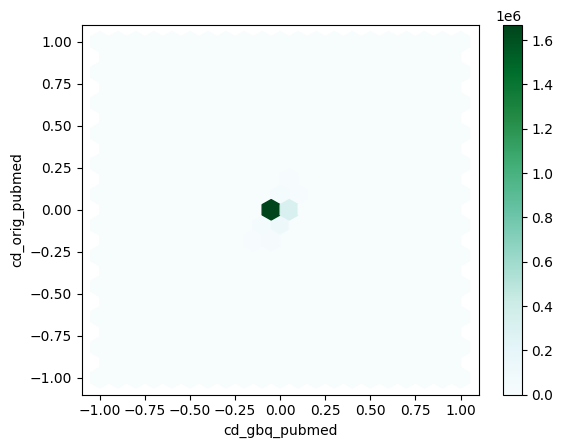

In [ ]:
tmp.plot(kind='hexbin', x='cd_gbq_pubmed', y='cd_orig_pubmed', gridsize = 20)

Divide up all papers into three categories for Funk's and mine CD
Disruptive:
	 Funk CD: highest 1.0% of publications i.e. Funk CD_5 > 0.5 
	 My CD:   highest 1.0% of publications i.e. My CD_5 > 0.2 
Consolidating:
	 Funk CD: lowest 1.0% of publications i.e. Funk CD_5 < -0.2 
	 My CD:   lowest 1.0% of publications i.e. My CD_5 < -0.1 
Neutral: everything in the middle


cd_gbq_pubmed                              cd_orig_pubmed  \
my_class      consolidating  neutral disruptive      All  consolidating   
orig_class                                                                
consolidating         12306    15357        607    28270          12306   
neutral               10638  2256621       7946  2275205          10638   
disruptive              416     8113      14708    23237            416   
All                   23360  2280091      23261  2326712          23360   

                                            
my_class       neutral disruptive      All  
orig_class                                  
consolidating    15357        607    28270  
neutral        2256621       7946  2275205  
disruptive        8113      14708    23237  
All            2280091      23261  2326712

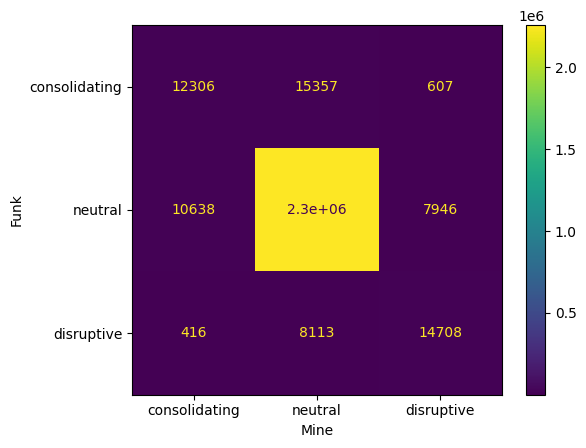

In [ ]:
q=0.01

print(f"Divide up all papers into three categories for Funk's and mine CD")
print(f"Disruptive:")
print(f"\t Funk CD: highest {q:0.1%} of publications i.e. Funk CD_5 > {tmp.cd_orig_pubmed.quantile(1-q):.1} ")
print(f"\t My CD:   highest {q:0.1%} of publications i.e. My CD_5 > {tmp.cd_gbq_pubmed.quantile(1-q):.1} ")
print(f"Consolidating:")
print(f"\t Funk CD: lowest {q:0.1%} of publications i.e. Funk CD_5 < {tmp.cd_orig_pubmed.quantile(q):.1} ")
print(f"\t My CD:   lowest {q:0.1%} of publications i.e. My CD_5 < {tmp.cd_gbq_pubmed.quantile(q):.1} ")
print(f"Neutral: everything in the middle")


tmp["orig_class"]=pd.qcut(tmp.cd_orig_pubmed,   [0, q, 1-q, 1],     labels=["consolidating", "neutral", "disruptive"])
tmp["my_class"]  =pd.qcut(tmp.cd_gbq_pubmed,    [0, q,   1-q,   1], labels=["consolidating", "neutral", "disruptive"])
display(pd.pivot_table(tmp, index="orig_class", columns="my_class", aggfunc="count", margins=True))
ConfusionMatrixDisplay.from_predictions(tmp["orig_class"], tmp["my_class"], labels = ["consolidating", "neutral", "disruptive"])
color = 'black'
plt.ylabel('Funk', color=color)
plt.xlabel('Mine', color=color)
plt.show()

In [ ]:
print(classification_report(tmp["orig_class"], tmp["my_class"], digits=2))

               precision    recall  f1-score   support

consolidating       0.53      0.44      0.48     28270
   disruptive       0.63      0.63      0.63     23237
      neutral       0.99      0.99      0.99   2275205

     accuracy                           0.98   2326712
    macro avg       0.72      0.69      0.70   2326712
 weighted avg       0.98      0.98      0.98   2326712

